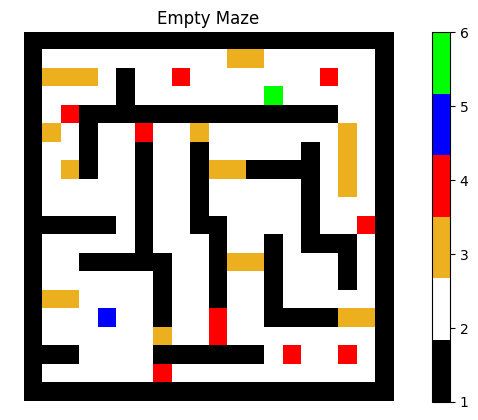

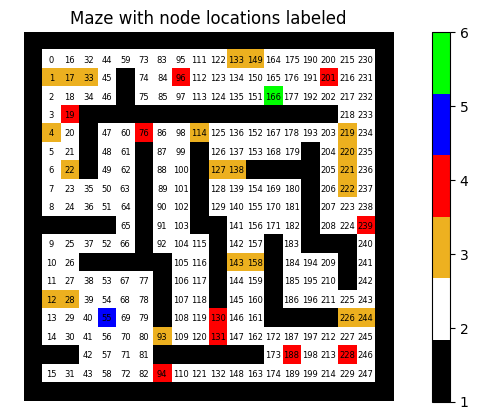

In [1]:

# Map setup
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.io import loadmat

# Load the maze data
maze_data = loadmat('Maze.mat')  # Ensure this matches the structure of the .mat file
Maze = maze_data['Maze']

arrow_dirs = ['↑', '↓', '←', '→']


# Set the size of the matrix
m, n = Maze.shape  # Use the actual shape of the Maze data

# Define a color map for the values in the matrix
cmap = ListedColormap([[0, 0, 0],  # black for 1
                 [1, 1, 1],  # white for 2
                 [0.9290, 0.6940, 0.1250],  # tan for 3
                 [1, 0, 0],  # red for 4
                 [0, 0, 1],  # blue for 5
                 [0, 1, 0]])  # green for 6

# Create a figure to display the matrix
plt.figure()
plt.imshow(Maze, cmap=cmap)
plt.title("Empty Maze")
plt.colorbar()
plt.axis('equal')
plt.axis('off')

# Convert Maze into graph
adjacencyMatrix = np.empty((m, n, 4), dtype=object)
for i in range(1, m-1):  # Corrected for 0-indexing
    for j in range(1, n-1):
        adjacencyMatrix[i, j, 0] = [i-1, j]  # Up
        adjacencyMatrix[i, j, 1] = [i+1, j]  # Down
        adjacencyMatrix[i, j, 2] = [i, j-1]  # Left
        adjacencyMatrix[i, j, 3] = [i, j+1]  # Right

nodes = (Maze > 1).astype(int)

# Initialize a variable to keep track of the linear index
linear_index = 0

# Create a matrix to hold the indices
nodeLocations = np.full(Maze.shape, -1, dtype=int)

linear_indices = []
# Iterate over the array column by column
for j in range(n):  # Column index
    for i in range(m):  # Row index
        if nodes[i, j] > 0:
            nodeLocations[i, j] = linear_index
            linear_indices.append(j*n+i)
            linear_index += 1

# Convert linear indices to row and column indices
col_indices, row_indices = np.unravel_index(linear_indices, nodes.T.shape)

# Combine row and column indices horizontally
nodes = np.column_stack((row_indices, col_indices))

# Create a figure to display the matrix with node locations labeled
plt.figure()
plt.imshow(Maze, cmap=cmap)
plt.title("Maze with node locations labeled")
plt.colorbar()
plt.axis('equal')
plt.axis('off')

# Adjust the text placement to match the provided image
for (i, j), index in np.ndenumerate(nodeLocations):
    if index != -1:
        plt.text(j, i, str(index), fontsize=6, ha='center', va='center', color='black')

plt.show()


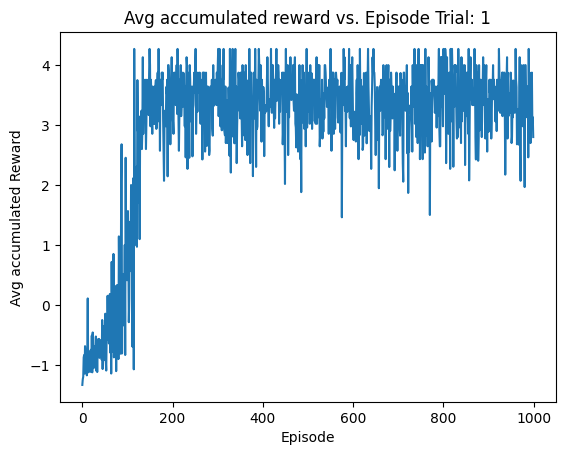

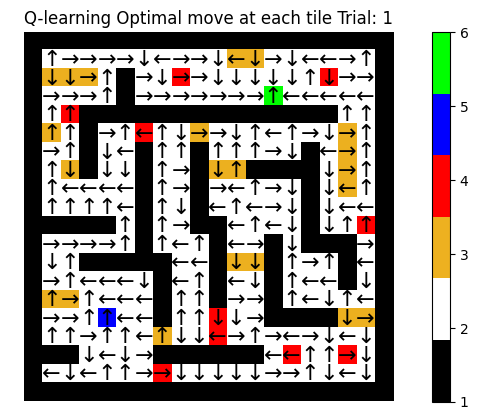

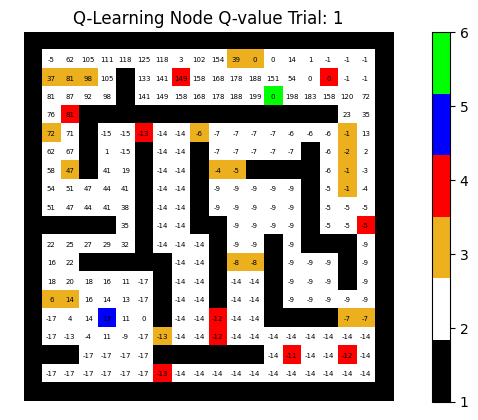

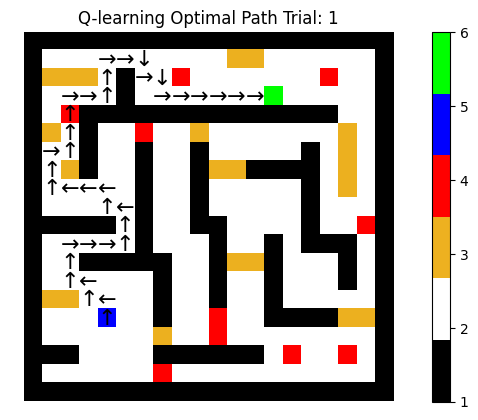

KeyboardInterrupt: 

In [2]:
## Q-learning
def updateEGreedy(Q, epsilon):
    EGreedyRow = np.ones(len(Q)) * 0.25
    if np.all(Q == Q[0]):
        EGreedyRow[:] = 0.25
    else:
        argmax = np.argmax(Q)
        EGreedyRow[:] = epsilon / 4
        EGreedyRow[argmax] += 1 - epsilon
    return EGreedyRow

def actionFromPolicy(arr):
    cp = np.concatenate(([0], np.cumsum(arr)))
    r = np.random.rand()
    index = np.where(r > cp)[0][-1]
    return index

# Initialize Q and parameters
pDesiredAction = 0.98
pUndesiredAction = (1 - pDesiredAction) / 3
gamma = 0.95
alpha = 0.3
epsilon = 0.1
episodeTotal = 1000
maxStepsPerEpisode = 1000

actionNoArr = [0, 1, 2, 3]

for trial in range(1, 11):
    Qsa0 = np.zeros((nodes.shape[0], 4))
    piEGreedy = np.ones((nodes.shape[0], 4)) * 0.25
    Qsa = Qsa0.copy()
    SARS = np.zeros((1, 4))

    avgAccumulatedRewardQ = np.zeros((episodeTotal, 1))

    for episode in range(1, episodeTotal + 1):
        # Episode loop
        startingState = 55
        SARS = np.zeros((1, 4))
        SARS[0, 0] = startingState
        rewardSum = 0
        for step in range(1, maxStepsPerEpisode + 1):
            # Step loop
            piEGreedy[int(SARS[step - 1, 0]), :] = updateEGreedy(Qsa[int(SARS[step - 1, 0]), :], epsilon)
            desiredActionNo = actionFromPolicy(piEGreedy[int(SARS[step - 1, 0]), :])
            if np.random.rand() > pDesiredAction:
                undesiredActions = [action for action in actionNoArr if action != desiredActionNo]
                action = np.random.choice(undesiredActions, 1)[0]
            else:
                action = desiredActionNo
            
            SARS[step - 1, 1] = action
            s = int(SARS[step - 1, 0])
            
            reward = 0
            sPrime = adjacencyMatrix[nodes[s, 0], nodes[s, 1], action]  # S'
            tileValue = Maze[sPrime[0], sPrime[1]]
            
            if tileValue == 1:  # Bounce off of wall
                sPrime = [nodes[s, 0], nodes[s, 1]]
                tileValue = Maze[sPrime[0], sPrime[1]]
            
            sPrime = nodeLocations[sPrime[0], sPrime[1]]
            if tileValue == 2:
                    reward = -1  # Plain tile
            elif tileValue == 3:
                reward = -11  # Bump
            elif tileValue == 4:
                reward = -6  # Oil
            elif tileValue == 5:
                reward = -1  # Start tile
            elif tileValue == 6:
                reward = 199  # Goal
            
            rewardSum = rewardSum + reward
            SARS[step - 1, 2] = reward
            SARS[step - 1, 3] = sPrime
            
            Qsa[s, action] = Qsa[s, action] + alpha * (reward + gamma * np.max(Qsa[sPrime, :]) - Qsa[s, action])
            
            if sPrime != 166:
                SARS = np.vstack([SARS, [0, 0, 0, 0]])
                SARS[step, 0] = sPrime
            else:
                break
        
        avgAccumulatedRewardQ[episode - 1, 0] = rewardSum / step

    QlearningPolicy = np.empty(nodes.shape[0], dtype='U1')
    QMaxVals = np.zeros(nodes.shape[0])
    for i in range(nodes.shape[0]):
        Ind = np.argmax(Qsa[i, :])
        QlearningPolicy[i] = arrow_dirs[Ind]
        QMaxVals[i] = np.max(Qsa[i, :])

    plt.figure()
    plt.plot(avgAccumulatedRewardQ)
    plt.title("Avg accumulated reward vs. Episode Trial: " + str(trial))
    plt.xlabel("Episode")
    plt.ylabel("Avg accumulated Reward")
    plt.show()

    plt.figure()
    plt.imshow(Maze, cmap=cmap)
    plt.title("Q-learning Optimal move at each tile Trial: " + str(trial))
    plt.colorbar()
    plt.axis('equal')
    plt.axis('off')
    for i in range(1, 20):
        for j in range(1, 20):
            if nodeLocations[i, j] > -1:
                arrow_dir = QlearningPolicy[nodeLocations[i, j]]
                plt.text(j, i, arrow_dir, fontsize=16, horizontalalignment='center', verticalalignment ='center')
    plt.show()

    plt.figure()
    plt.imshow(Maze, cmap=cmap)
    plt.title("Q-Learning Node Q-value Trial: " + str(trial))
    plt.colorbar()
    plt.axis('equal')
    plt.axis('off')
    for i in range(1, 20):
        for j in range(1, 20):
            node = nodeLocations[j, i]
            if node > -1:
                val = str(round(QMaxVals[node]))
                plt.text(i, j, val, fontsize=5, horizontalalignment='center',verticalalignment ='center')
    plt.show()

    plt.figure()
    plt.imshow(Maze, cmap=cmap)
    plt.title("Q-learning Optimal Path Trial: " + str(trial))
    plt.colorbar()
    plt.axis('equal')
    plt.axis('off')
    node = 55
    while node != 166:
        y = nodes[node, 0]
        x = nodes[node, 1]
        action = QlearningPolicy[nodeLocations[y, x]]
        plt.text(x, y, action, fontsize=16, horizontalalignment='center', verticalalignment ='center')
        nextCoordinate = adjacencyMatrix[y, x, arrow_dirs.index(action)]
        nextNode = nodeLocations[nextCoordinate[0], nextCoordinate[1]]
        node = nextNode
    plt.show()
    
    
